<a href="https://colab.research.google.com/github/shokru/carbon_emissions/blob/main/energy_emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy and emissions

This notebook aims to show the link (if not causal relationship) between **energy consumption** (or production) and **Greenhouse Gas** (GHG) emissions.

This notebook is coded in Python and relies on a few libraries (or packages), which we load below.


In [2]:
import pandas as pd                      # This library is for data wrangling
import seaborn as sns                    # This is one library for plotting
import matplotlib.pyplot as plt          # Yet another library for visualization
import plotly.express as px              # This is another library for plots
import requests
import json
from zipfile import ZipFile
from io import BytesIO
import warnings                          # This is to remove warning to keep output clean
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 6)     # First 3 and last 3 rows will be shown

## Emissions data: long-term perspective


We will resort to two datasets for emissions: one for a dynamic analysis on GHG and one for a cross-sectional study on carbon emissions only.   
Highly granular data for European cities in 2018 has been released at https://openghgmap.net/data/, but we will use a dynamic one.   
As we will see, depending on the data source, the results may substantially change.  
We obtain the first one from [**Climate Watch**](https://www.climatewatchdata.org/ghg-emissions).

We also recommend a visit to: https://ourworldindata.org/co2-dataset-sources.


In [10]:
#url = 'https://wri-public-data.s3.amazonaws.com/resourcewatch/cli_008_greenhouse_gas_emissions_country_sector.zip'
#filename = requests.get(url).content
#zf = ZipFile( BytesIO(filename), 'r')
#zf.getinfo('historical_emissions.zip')
#zf = ZipFile(zf.open('historical_emissions.zip'))
#data_ghg = pd.read_csv(zf.open('historical_emissions.csv'))

url = 'https://raw.githubusercontent.com/shokru/carbon_emissions/main/historical_emissions.csv'
data_ghg = pd.read_csv(url)
data_ghg

,ISO,Country,Data source,Sector,Gas,Unit,2020,2019,2018,2017,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,WORLD,World,Climate Watch,Total including LUCF,All GHG,MtCO₂e,47513.15,49880.60,49585.91,48390.92,...,35264.63,35261.24,35715.00,34351.00,33960.87,33162.74,32884.18,32736.21,32835.51,32661.42
1,WORLD,World,Climate Watch,Total excluding LUCF,All GHG,MtCO₂e,46120.92,48089.62,48069.81,47035.21,...,33329.42,33134.92,32918.47,32523.97,31923.72,31131.20,30852.31,30704.76,30804.06,30629.97
2,WORLD,World,Climate Watch,Energy,All GHG,MtCO₂e,35475.65,37612.13,37707.06,36804.52,...,25446.72,25315.23,25150.27,24730.57,24210.55,23551.65,23450.49,23315.17,23432.48,23283.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,LIE,Liechtenstein,Climate Watch,Other Fuel Combustion,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2728,NIU,Niue,Climate Watch,Waste,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2729,NIU,Niue,Climate Watch,Fugitive Emissions,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All units are in equivalents of CO$_2$ metric tons, so we can remove the column. Same for the data source, which is not useful for us now - as well as for "Gas".  
We need to reshape the data to a 'long' format.

In [11]:
data_ghg = data_ghg.drop(labels = ['Unit', 'Data source', 'Gas'], axis=1)
data_ghg = pd.wide_to_long(data_ghg,
                stubnames = [''],
                i = ['Country', 'Sector'],
                j = 'Year').reset_index()
data_ghg = data_ghg.rename(columns = {"": "Emissions"})
data_ghg

,Country,Sector,Year,ISO,Emissions
0,World,Total including LUCF,2020,WORLD,47513.15
1,World,Total including LUCF,2019,WORLD,49880.60
2,World,Total including LUCF,2018,WORLD,49585.91
...,...,...,...,...,...
84627,Niue,Fugitive Emissions,1992,NIU,NaN
84628,Niue,Fugitive Emissions,1991,NIU,NaN
84629,Niue,Fugitive Emissions,1990,NIU,NaN


Let's see which are the sector categories.

In [12]:
data_ghg.Sector.unique() # List of sectors

array(['Total including LUCF', 'Total excluding LUCF', 'Energy',
       'Electricity/Heat', 'Transportation', 'Manufacturing/Construction',
       'Agriculture', 'Fugitive Emissions', 'Industrial Processes',
       'Building', 'Waste', 'Land-Use Change and Forestry',
       'Bunker Fuels', 'Other Fuel Combustion'], dtype=object)

That's a lot! Let's see the dynamic.

In [13]:
data_ghg_global_plot = data_ghg.query('Sector != "Total including LUCF"').query('Sector != "Total excluding LUCF"') # Remove some sectors
data_ghg_global_plot = data_ghg_global_plot.query('Country == "World"')
data_ghg_global_plot = data_ghg_global_plot.drop_duplicates(subset = ['Year', 'Sector'])
data_ghg_global_plot = data_ghg_global_plot.pivot(index = ['Year'],
                                                  columns = 'Sector',
                                                  values = "Emissions").reset_index()
data_ghg_global_plot

Sector,Year,Agriculture,Building,Bunker Fuels,Electricity/Heat,Energy,Fugitive Emissions,Industrial Processes,Land-Use Change and Forestry,Manufacturing/Construction,Other Fuel Combustion,Transportation,Waste
0,1990,4978.93,2880.92,635.70,8645.45,23283.88,2280.97,1002.76,2031.44,3980.38,769.85,4726.31,1364.40
1,1991,4968.92,2906.64,643.45,8786.72,23432.48,2300.96,1007.48,2031.44,3902.86,770.79,4764.50,1395.18
2,1992,4948.40,2795.52,680.74,8946.56,23315.17,2245.49,1022.92,2031.44,3769.96,685.90,4871.73,1418.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,2018,5788.68,3101.11,1330.14,15880.51,37707.06,3371.53,2967.21,1516.09,6248.98,624.02,8480.91,1606.86
29,2019,5783.42,3040.91,1324.51,15819.97,37612.13,3420.96,3064.20,1790.99,6252.65,596.88,8480.77,1629.87
30,2020,5865.47,2980.52,938.14,15181.35,35475.65,3223.69,3126.93,1392.23,6223.02,579.05,7288.01,1652.87


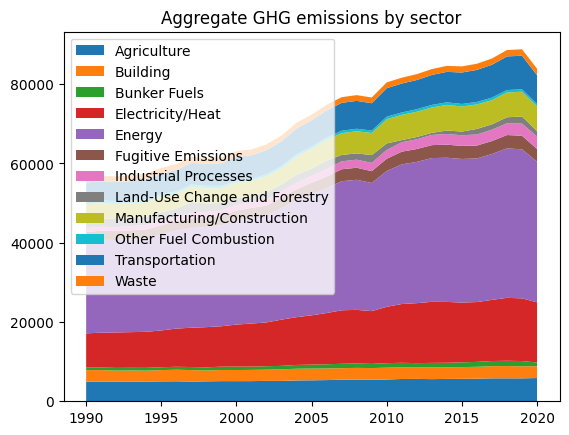

In [14]:
plt.stackplot(data_ghg_global_plot['Year'],
              data_ghg_global_plot.drop('Year', axis = 1).to_numpy().transpose(),
              labels = list(data_ghg_global_plot.drop('Year', axis = 1).columns))
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"]=(16, 10)
plt.title('Aggregate GHG emissions by sector')
plt.show()

##  Emissions: recent high frequency data
Our second source for emissions comes from Carbon Monitor: https://carbonmonitor.org.   

The website samples emissions at the daily frequency!


In [15]:
url = 'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_global'
data_carbon = pd.read_csv(url, skiprows = 0)
data_carbon['date'] = pd.to_datetime(data_carbon['date'],format='%d/%m/%Y') # Correct date format
# Below, we switch to capital letters for 1st character of column names
data_carbon = data_carbon.rename(columns={'country': 'Country',
                                          'date': 'Date',
                                          'sector': 'Sector',
                                          'value': 'Value',
                                          'timestamp': 'Timestamp'})
data_carbon

,Country,Date,Sector,Value,Timestamp
0,Brazil,2019-01-01,Domestic Aviation,0.023750,1546300800
1,Brazil,2019-01-01,Ground Transport,0.201663,1546300800
2,Brazil,2019-01-01,Industry,0.240156,1546300800
...,...,...,...,...,...
153381,WORLD,2023-12-31,International Aviation,1.599840,1703980800
153382,WORLD,2023-12-31,Power,37.361200,1703980800
153383,WORLD,2023-12-31,Residential,15.252700,1703980800


Let's have a look at one country in particular.

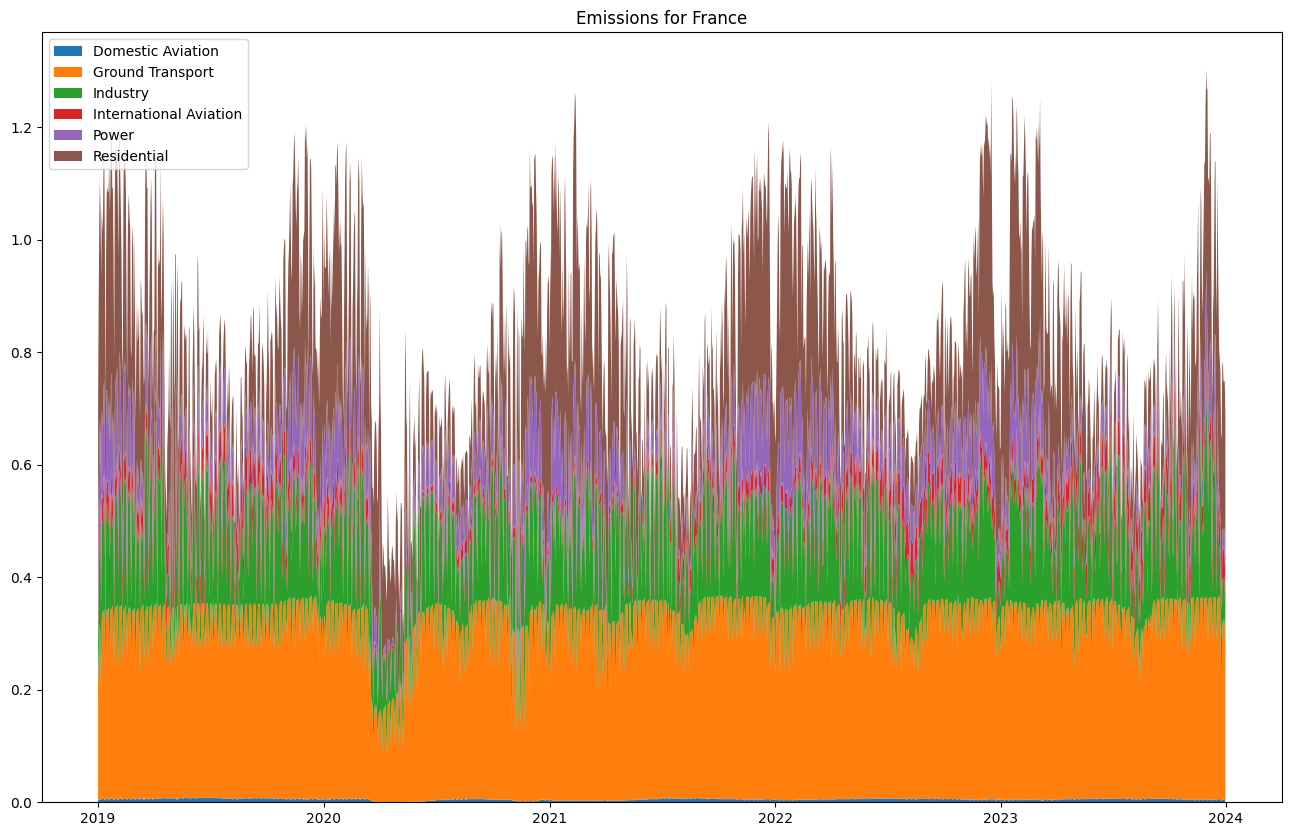

In [16]:
data_fr = data_carbon.query('Country == "France"')
data_fr = data_fr.drop_duplicates(subset = ['Date', 'Sector'])
data_fr = data_fr.pivot(index = 'Date',
                        columns = 'Sector',
                        values = "Value").reset_index()
plt.stackplot(data_fr['Date'],
              data_fr.drop('Date', axis = 1).to_numpy().transpose(),
              labels = list(data_fr.drop('Date', axis = 1).columns))
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"]=(16, 10)
plt.title('Emissions for France')
plt.show()

**NOTE**: the data starts in 2019 "only". We leave it aside for now....

## Energy data

For **energy** production and consumption, we use data compiled by the [Energy Institute](https://www.energyinst.org/statistical-review/resources-and-data-downloads). While it is undeniably a corporate source (as it originates from **BP** and is handled by professionals), it is widely considered as reliable, especially for non renewable energies. For renewables, the post https://www.resilience.org/stories/2017-08-02/how-bp-is-minimizing-renewable-energy-in-its-statistical-review/ contends that the company purposefully minimizes the numbers. For our study, this will not be a major issue.. While it is undeniably a corporate source, it is widely considered as reliable, especially for non renewable energies. For renewables, the post https://www.resilience.org/stories/2017-08-02/how-bp-is-minimizing-renewable-energy-in-its-statistical-review/ contends that the company purposefully minimizes the numbers. For our study, this will not be a major issue.   
Below, the file is heavy, so importation may take time...

In [17]:
url = 'https://www.energyinst.org/__data/assets/excel_doc/0003/1055757/Consolidated-Dataset-Narrow-format.xlsx'
data_energy_sources = pd.read_excel(url) # Reads the online file
data_energy_sources                      # Shows the result

,Country,Year,ISO3166_alpha3,ISO3166_numeric,Region,SubRegion,OPEC,EU,OECD,CIS,Var,Value
0,Brazil,2004,BRA,76.0,S. & Cent. America,South America,0.0,0.0,0.0,0.0,biodiesel_cons_kboed,0.000000
1,Brazil,2005,BRA,76.0,S. & Cent. America,South America,0.0,0.0,0.0,0.0,biodiesel_cons_kboed,0.010641
2,Brazil,2006,BRA,76.0,S. & Cent. America,South America,0.0,0.0,0.0,0.0,biodiesel_cons_kboed,1.025554
...,...,...,...,...,...,...,...,...,...,...,...,...
277861,Vietnam,2020,VNM,704.0,Asia Pacific,Asia Pacific,0.0,0.0,0.0,0.0,wind_twh_net,1.063052
277862,Vietnam,2021,VNM,704.0,Asia Pacific,Asia Pacific,0.0,0.0,0.0,0.0,wind_twh_net,2.368540
277863,Vietnam,2022,VNM,704.0,Asia Pacific,Asia Pacific,0.0,0.0,0.0,0.0,wind_twh_net,7.964457


We see that the suffixes tell the units in which the values are expressed. For instance, "ej" refers to **exajoule**, which is 10^18 joules while "pt" to **petajoule**, which is 10^15 joules. The joule is a classical unit used to quantify amounts of energy.  
For obvious **consistency** reasons, we need to put all joule type units at the same scale, which we choose to be the petajoule. Hence, we need to multiply the exajoule values by 1,000.

In [18]:
data_energy_sources = data_energy_sources[data_energy_sources['Var'].str.endswith('j')]
data_energy_sources['Scale'] = data_energy_sources['Var'].transform(lambda x: 1000 if x.endswith('ej') else 1) # Scale column
data_energy_sources['Value'] = data_energy_sources['Value'] * data_energy_sources['Scale']            # Adjusted value
data_energy_sources = data_energy_sources.loc[:, ['Country', 'Year', 'Region', 'Var', 'Value']]       # Keeping 5 columns
data_energy_sources['Var'] = data_energy_sources['Var'].map(lambda x: x.lstrip('+-').rstrip('_ej'))   # Remove suffix
data_energy_sources['Var'] = data_energy_sources['Var'].map(lambda x: x.lstrip('+-').rstrip('_pj'))   # Remove suffix
data_energy_sources = data_energy_sources.rename(columns = {'Value' : 'Consumption'})                 # Change name of column
categories = ['wind',
              'solar',
              'renewables',
              'ren_power',
              'oilcons',
              'nuclear',
              'hydro',
              'gascons',
              'ethanol_cons',
              'coalcons',
              'biogeo',
              'biofuels_cons',
              'biodiesel_cons']
data_energy_sources = data_energy_sources[data_energy_sources['Var'].isin(categories)]                 # Reduce number of variables
data_energy_sources

,Country,Year,Region,Var,Consumption
708,Brazil,2004,S. & Cent. America,biodiesel_cons,0.000000
709,Brazil,2005,S. & Cent. America,biodiesel_cons,0.023767
710,Brazil,2006,S. & Cent. America,biodiesel_cons,2.290630
...,...,...,...,...,...
268367,Vietnam,2020,Asia Pacific,wind,10.152299
268368,Vietnam,2021,Asia Pacific,wind,22.537105
268369,Vietnam,2022,Asia Pacific,wind,75.506955


## Visualizing trends

In order to plot macro trends, we must aggregate series

In [19]:
data_energy_sources.query('Country == "Total World"')

,Country,Year,Region,Var,Consumption
1325,Total World,1965,NaN,biodiesel_cons,0.000000
1326,Total World,1966,NaN,biodiesel_cons,0.000000
1327,Total World,1967,NaN,biodiesel_cons,0.000000
...,...,...,...,...,...
267903,Total World,2020,NaN,wind,15070.253526
267904,Total World,2021,NaN,wind,17465.739781
267905,Total World,2022,NaN,wind,19755.361131


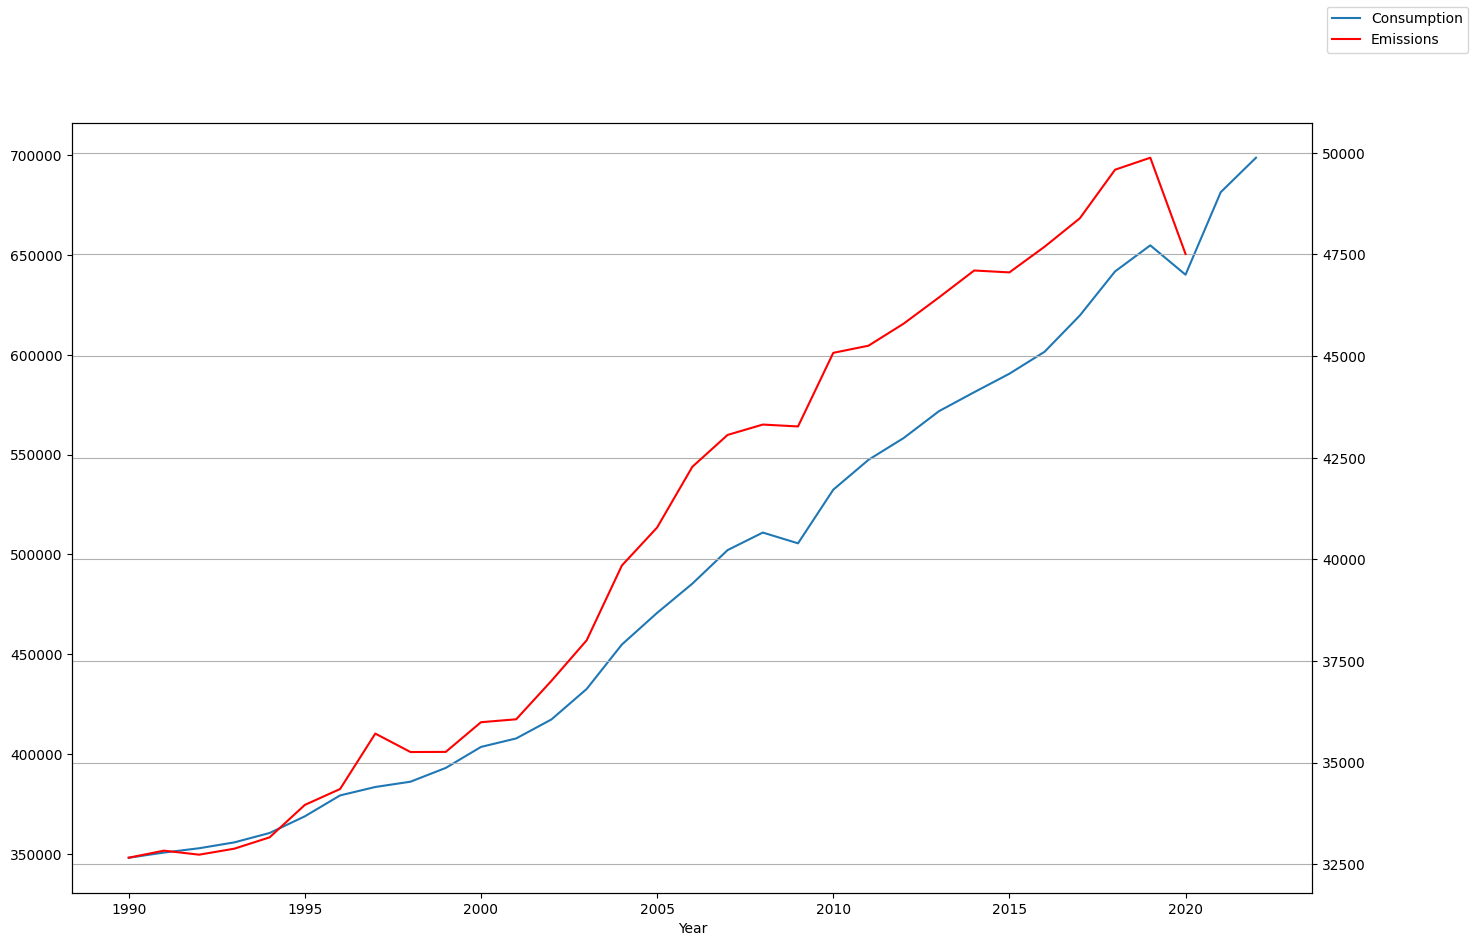

In [20]:
ax = data_energy_sources.query('Country == "Total World" & Year > 1989').pivot_table(values=['Consumption'],  # This creates the pivot table
                                       aggfunc='sum',
                                       index=['Country','Year']).reset_index().plot(x = "Year",
                                                                                    y = "Consumption",
                                                                                    legend = False)


ax2 = ax.twinx()
data_ghg.query('Country == "World" & Sector == "Total including LUCF"').plot(x = "Year", y = "Emissions", ax = ax2, legend = False, color = "r")
ax.figure.legend()
plt.grid()
plt.show()
plt.rcParams["figure.figsize"]=(10, 6)

The link between the two curves is astonishing (the emissions data stops a bit early).   
Let's have a look at the breakdown in terms of energy source.

In [21]:
data_energy_sectors = data_energy_sources.query('Country == "Total World"').drop_duplicates(subset = ['Year', 'Var'])
data_energy_sectors = data_energy_sectors.pivot(index = ['Year'],
                                                                          columns = 'Var',
                                                                          values = "Consumption").reset_index()
data_energy_sectors

Var,Year,biodiesel_cons,biofuels_cons,biogeo,coalcons,ethanol_cons,gascons,hydro,nuclear,oilcons,ren_power,renewables,solar,wind
0,1965,0.000000,32.507502,201.416710,58104.642195,32.507500,22693.777576,9827.591986,260.889654,64787.507863,201.416710,233.924212,0.000000,0.000000
1,1966,0.000000,33.155438,222.255389,58766.738333,33.155437,24727.761725,10472.890164,351.737912,69669.562850,222.255389,255.410827,0.000000,0.000000
2,1967,0.000000,33.781376,224.472158,57818.914434,33.781376,26546.643173,10706.289546,418.878629,74679.515914,224.472158,258.253533,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,2020,1695.467188,3865.529666,7857.710471,152040.205250,2170.062520,138972.254156,41212.897298,24396.718470,174994.720816,31005.770551,34871.300217,8077.806453,15070.253526
56,2021,1783.330154,4114.338524,8407.122034,160433.339109,2331.008300,146414.377377,40400.496167,25333.448449,184858.762151,35851.447625,39965.786149,9978.585719,17465.739781
57,2022,1922.574928,4317.143793,8689.707481,161474.539387,2394.568816,141886.963900,40679.340697,24128.421783,190690.521187,40858.723065,45175.866858,12413.654264,19755.361131


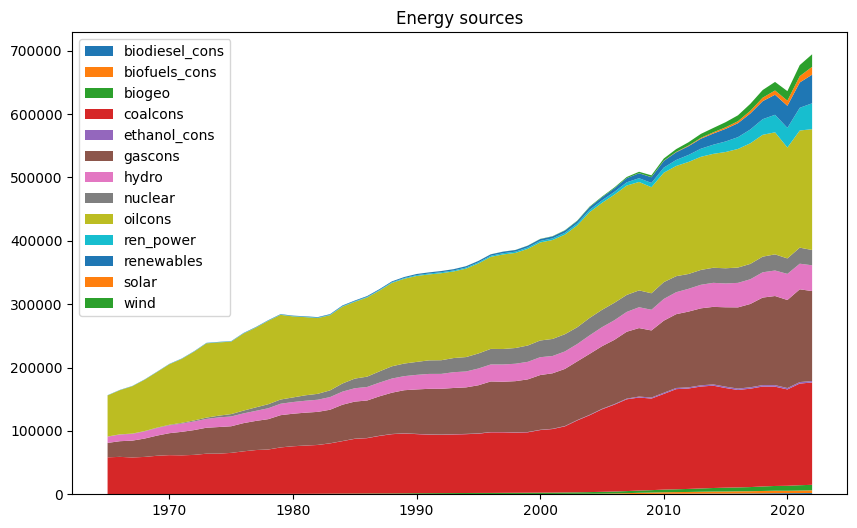

In [22]:
plt.stackplot(data_energy_sectors['Year'],
              data_energy_sectors.drop('Year', axis = 1).to_numpy().transpose(),
              labels = list(data_energy_sectors.drop('Year', axis = 1).columns))
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"]=(16, 10)
plt.title('Energy sources')
plt.show()

## Scatterplots on long-term data

Let's now look at the granular data (country level).  
To do so, we must merge the two datasets.

In [23]:
data_merged = pd.merge(data_energy_sources.replace("US", "United States"),
                       data_ghg, on = ['Year', 'Country'])
data_merged

,Country,Year,Region,Var,Consumption,Sector,ISO,Emissions
0,Brazil,2004,S. & Cent. America,biodiesel_cons,0.000000,Total including LUCF,BRA,2002.36
1,Brazil,2004,S. & Cent. America,biodiesel_cons,0.000000,Total excluding LUCF,BRA,886.64
2,Brazil,2004,S. & Cent. America,biodiesel_cons,0.000000,Agriculture,BRA,463.57
...,...,...,...,...,...,...,...,...
328913,Vietnam,2020,Asia Pacific,wind,10.152299,Other Fuel Combustion,VNM,7.17
328914,Vietnam,2020,Asia Pacific,wind,10.152299,Bunker Fuels,VNM,1.50
328915,Vietnam,2020,Asia Pacific,wind,10.152299,Land-Use Change and Forestry,VNM,-12.44


In [24]:
data_merged['Country'].unique()

array(['Brazil', 'United States', 'Argentina', 'Australia', 'Austria',
       'Belarus', 'Belgium', 'Bulgaria', 'Canada', 'China', 'Colombia',
       'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Ecuador',
       'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Kazakhstan', 'Latvia', 'Lithuania', 'Luxembourg',
       'Malaysia', 'Mexico', 'Netherlands', 'New Zealand', 'Norway',
       'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Slovakia',
       'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sweden',
       'Switzerland', 'Thailand', 'Ukraine', 'United Kingdom', 'Algeria',
       'Azerbaijan', 'Bangladesh', 'Chile', 'Egypt', 'Iran', 'Iraq',
       'Kuwait', 'Morocco', 'Oman', 'Pakistan', 'Qatar', 'Saudi Arabia',
       'Singapore', 'Sri Lanka', 'Turkmenistan', 'United Arab Emirates',
       'Uzbekistan', 'Venezuela', 'Vietnam'], dtype=object)

We can now look at correlations.

(0.008, 100000)

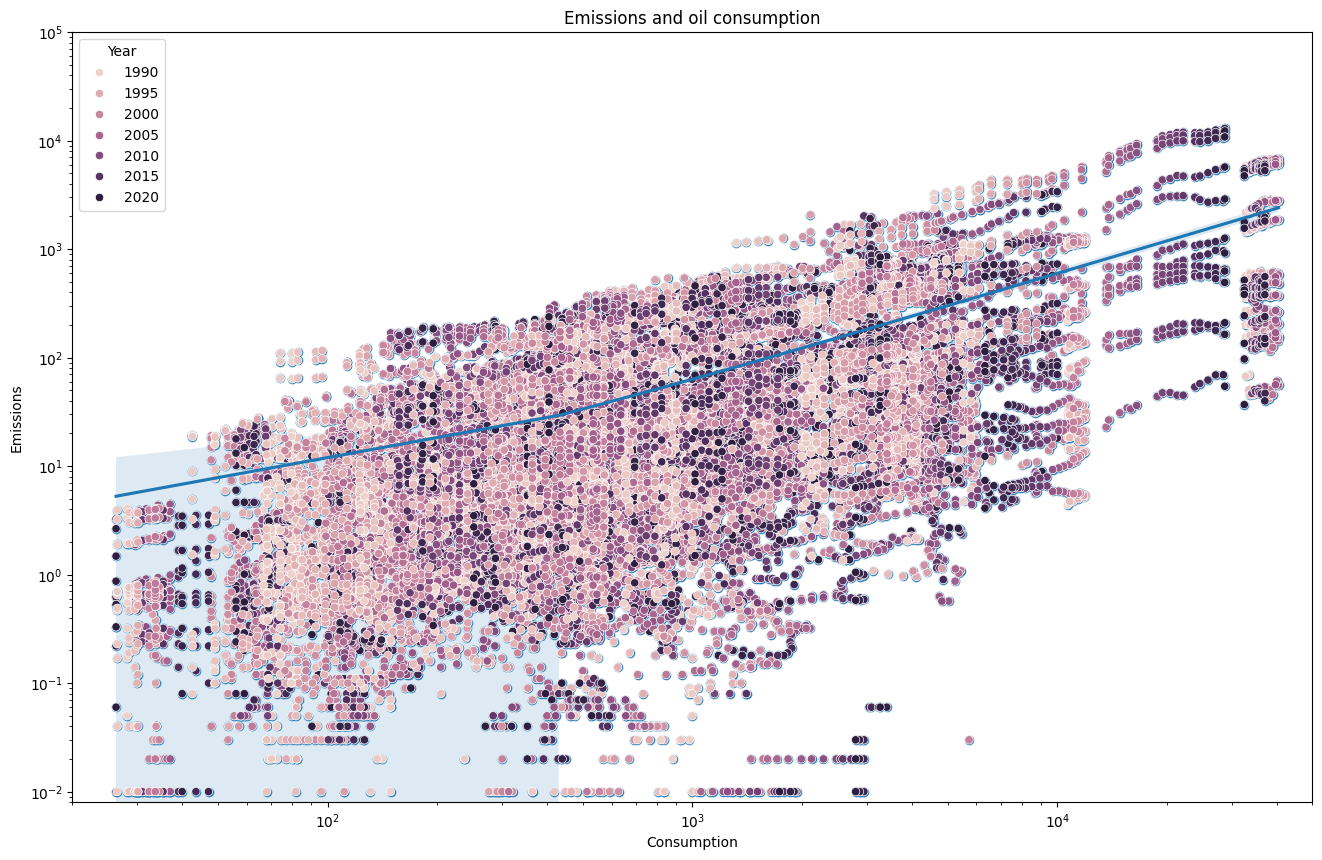

In [25]:
sns.regplot(data = data_merged.query('Var == "oilcons"'),
            x = "Consumption",
            y = "Emissions")
sns.scatterplot(data = data_merged.query('Var == "oilcons"'),
                x = 'Consumption',
                y = 'Emissions',
                hue = 'Year')
plt.xscale('log')
plt.yscale('log')
plt.title('Emissions and oil consumption')
plt.xlim(20,50000)
plt.ylim(0.008,10**5)

Each point represents one country and one year.  
Let's have a look at what happens for wind, but with a focus on regions/continent this time.




Text(0.5, 1.0, 'Emissions and renewable energy consumption')

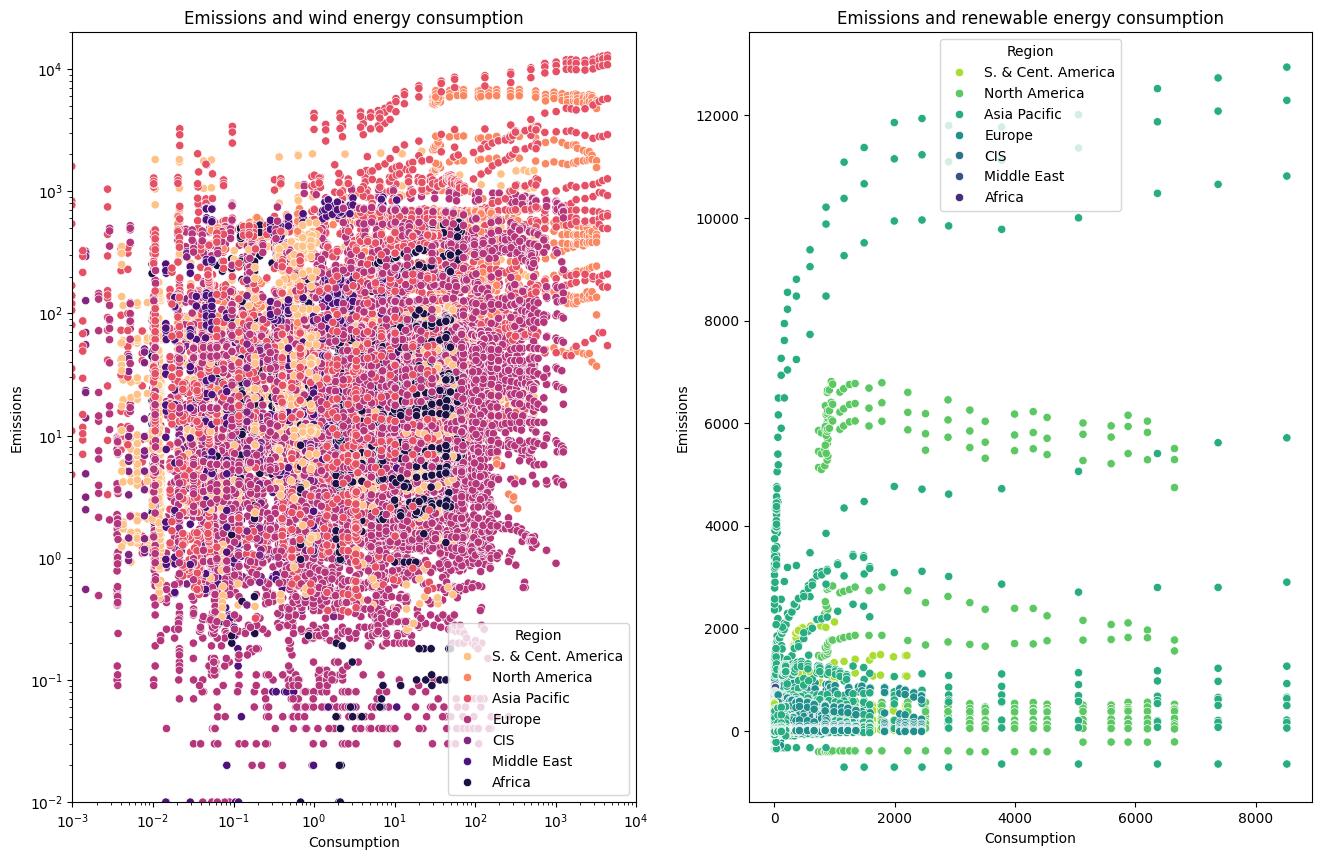

In [26]:
fig, ax = plt.subplots(1, 2)
sns.scatterplot(ax = ax[0],
                data = data_merged.query('Var == "wind"'),
                x = "Consumption",
                y = "Emissions",
                hue = "Region",
                palette = 'magma_r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Emissions and wind energy consumption')
ax[0].set_xlim(0.001,10**4)
ax[0].set_ylim(0.01,20000)

sns.scatterplot(ax = ax[1],
                data = data_merged.query('Var == "renewables"'),
                x = "Consumption",
                y = "Emissions",
                hue = "Region",
                palette = 'viridis_r')
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].set_title('Emissions and renewable energy consumption')
#ax[1].set_xlim(10**8,10**14)
#ax[1].set_ylim(1,10**5)

Things are less straightforward here....
Let's have a look at aggregate values for countries.


Text(0.5, 1.0, 'Emissions and renewable energy consumption')

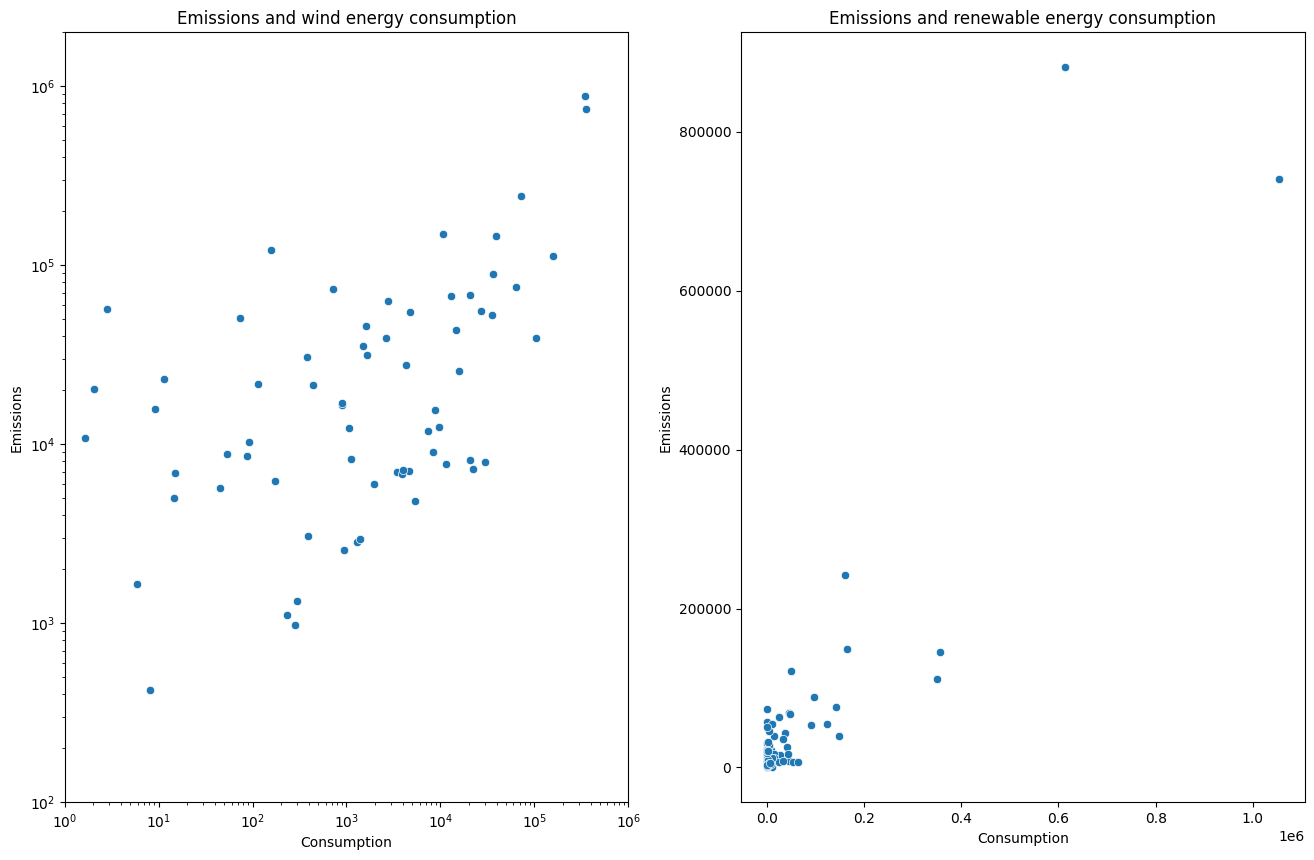

In [27]:
fig, ax = plt.subplots(1, 2)
sns.scatterplot(ax = ax[0],
                data = data_merged.query('Var == "wind"').pivot_table(values=['Consumption', 'Emissions'],
                                       aggfunc='sum',
                                       index=['Country']),
                x = "Consumption",
                y = "Emissions")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Emissions and wind energy consumption')
ax[0].set_xlim(1,10**6)
ax[0].set_ylim(100,2000000)

sns.scatterplot(ax = ax[1],
                data = data_merged.query('Var == "renewables"').pivot_table(values=['Consumption', 'Emissions'],
                                       aggfunc='sum',
                                       index=['Country']),
                x = "Consumption",
                y = "Emissions")
ax[1].set_title('Emissions and renewable energy consumption')

Here, both variables seem somewhat correlated.  
There are size effects (when we remove the log-scale): naturally, the US & China dominate for both criteria.  
We would need to look at *relative* values to see a different picture.

## Conclusion

Aggregate energy consumption is deeply linked with (and *probably* causes) emissions.   
For some energy types (e.g., wind), the link is less clear.   
The issue is that such types are marginal in the global mix of energy consumption, which is dominated by oil, coal and gas.  